$$
H = \frac{|p|^2}2 + \alpha \sin(\theta t) s + \frac{\gamma}{|q|}
$$

In [3]:
from integrators import contact as ic
from integrators.common import rk4s

In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [5]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha*np.sin(self.theta*t)

    def V(self, q, t):
        return self.gamma/np.linalg.norm(q, ord=2)
    
    def Vq(self, q, t):
        return -q*self.gamma/np.linalg.norm(q, ord=2)**3
    
    def lag(self, q,v,z,t):
        return .5*np.linalg.norm(v)**2 - self.V(q,t) - self.f(t)*z
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return -self.f(t)
    
    def energy(self, p, q, z, t):
        return 0.5*np.linalg.norm(p, ord=2)**2 + self.f(t)*z + self.V(q, t)

In [6]:
e = 0.2
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))])]
init = init_ecc(e)

energy = lambda pq, z, tspan: np.array([tpk.energy(pq[:,0][i], pq[:,1][i], z[i], t) for i,t in enumerate(tspan)])

## RK4 comparisons

In [ ]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.1
tf = 200000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, 0.0)
    solrk = rk4s(tpk, np.concatenate([p0,q0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.5,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             dc,
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.5, label="RK4")    

    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK01.pdf", bbox_inches='tight')
    fig.show()

In [ ]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.2
tf = 100000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1l, tpk, tspan, p0, q0, 0.0)
    solrk = rk4s(tpk, np.concatenate([p0,q0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
        
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
        
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
        
    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK02.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-7-b40d5f497362>:71: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


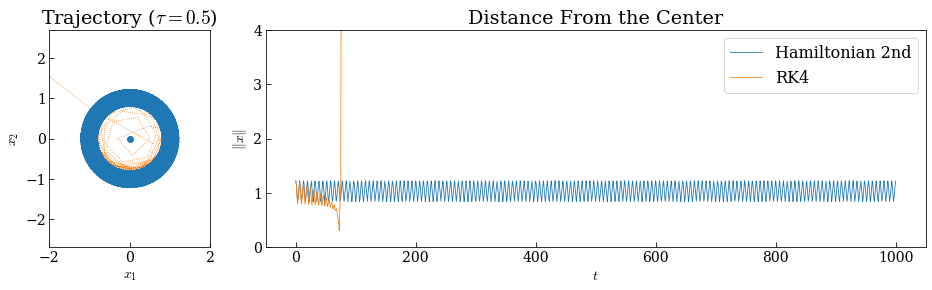

In [7]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1l, tpk, tspan, p0, q0, 0.0)
    solrk = rk4s(tpk, np.concatenate([p0,q0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist

    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")    
    
    fig.savefig(f"images/TPK05.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-8-c66d91d12080>:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


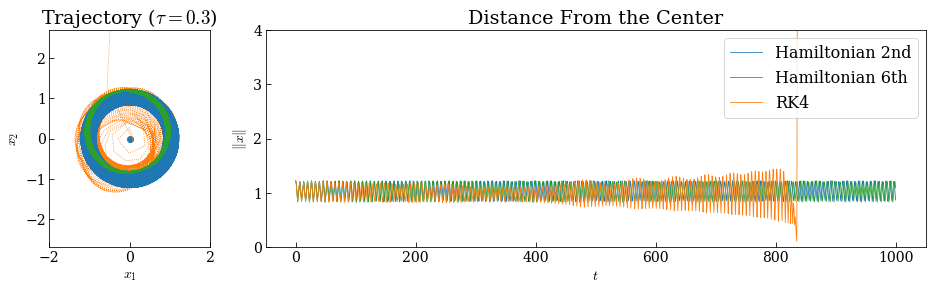

In [8]:
tpk = TimePerturbedKepler(-0.05, np.pi, -1)
dt = 0.3
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=len(tspan)
dc = np.empty(steps, dtype=np.float64)
dc6 = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0) in [init_ecc(0.2)]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1l, tpk, tspan, p0, q0, 0.0)
    sol6, sols6, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4s(tpk, np.concatenate([p0,q0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
        dist6=np.sqrt(sol6[i,1,0]*sol6[i,1,0] + sol6[i,1,1]*sol6[i,1,1])
        dc6[i]=dist6
        distrk=np.linalg.norm(solrk[i][2:])
        drk[i]=distrk
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.plot(sol6[:,1,0],
             sol6[:,1,1],
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             dc6,
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")
    
    axe.plot(tspan,
             drk,
             c='C1',
             linewidth=0.8, label="RK4")

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK03prec.pdf", bbox_inches='tight')

    fig.show()